### Imports

In [89]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from math import ceil

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.preprocessing import image

### Global variables

In [92]:

filelist = "../input/covidx-cxr2/train.txt"
image_path = '../input/covidx-cxr2/train'

test_file_list = "../input/covidx-cxr2/test.txt"
test_image_path = '../input/covidx-cxr2/test'

### Create keras learner sub class to control learning rate and print epoch wise output data

In [94]:
class LearnerCallback(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, model_patience,stop_patience, model_threshold, model_factor, model_dwell, model_name, model_freeze,model_batches, initial_epoch,training_epochs):
        super(LearnerCallback, self).__init__()
        self.lowest_vloss=np.inf
        self.model_threshold=model_threshold
        self.model_factor=model_factor
        self.stop_patience=stop_patience
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc=0.0
        self.model_dwell=model_dwell
        self.model=model
        self.initial_epoch=initial_epoch 
        self.model_batches=model_batches
        self.training_epochs=training_epochs
        best_weights=self.model.get_weights()
        self.model_patience=model_patience
        msg=' '
        if model_freeze==True:
            msgs=f' Training using { model_name} with static weights equal to imagenet weights. Initializing LearnerCallback callback.'
        else:
            msgs=f' Training all layers using { model_name}. '            
        print(msgs)

    def on_train_begin(self, logs=None):
        print('Starting model training ...')
    
    def on_train_end(self, logs=None):
        model.set_weights(LearnerCallback.best_weights)
        msg='Finished training the model. Weights set from epoch with the lowest loss'
        print(msg) 
        
    def on_train_batch_end(self, batch, logs=None):
        model_loss=logs.get('loss')
        model_acc=logs.get('accuracy')* 100   
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        
        # find time elapsed
        end_time=time.time()
        lapse=end_time-self.now
        
        # get the training accuracy and validation loss for the current epoch
        val_loss=logs.get('val_loss')
        acc=logs.get('accuracy')
        val_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        
        # get latest learning rate
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
        curr_lr=lr
        
        # adjust lr based on training accuracy if it is below a threshold.
        if acc < self.model_threshold:
            lr_param='accuracy'
            if acc>self.highest_tracc:
                self.highest_tracc=acc
                LearnerCallback.best_weights=self.model.get_weights()
                if val_loss<self.lowest_vloss:
                    self.lowest_vloss=val_loss
                self.count=0
                self.stop_count=0
                self.lr=lr
            else: 
                # check if there is no improvement in training accuracy till patience no. of epochs
                if self.count>=self.model_patience - 1:
                    
                    # reset learning rate by factor
                    self.lr= lr* self.model_factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

                    if self.model_dwell:
                        self.model.set_weights(LearnerCallback.best_weights)                      
                    else:
                        if val_loss<self.lowest_vloss:
                            self.lowest_vloss=val_loss
                    
                    self.count=0
                    self.stop_count=self.stop_count + 1
                else:
                    self.count=self.count + 1

        else: # if the training accuracy is above the required threshold, adjust learning rate on the basis of validation loss
            lr_param='val_loss'
            
            if val_loss < self.lowest_vloss:
                LearnerCallback.best_weights = self.model.get_weights()
                self.lowest_vloss = val_loss
                self.lr = lr
                self.count = 0 
                self.stop_count = 0
            else: # non improvement in validation loss
                if self.count >= self.model_patience - 1:    
                    if self.model_dwell:
                        self.model.set_weights(LearnerCallback.best_weights)
                    self.stop_count=self.stop_count + 1
                    self.count=0
                    self.lr=self.lr * self.model_factor   
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                else: 
                    self.count =self.count +1                   
                if acc > self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^4s}/{str(self.training_epochs):5s} {loss:^10.3f}{acc*101:^9.3f}{val_loss:^10.5f}{val_acc*101:^9.3f}{curr_lr:^10.5f}{self.lr:^10.5f}{lr_param:^12s}{lapse:^9.2f}'
        print(msg)
        if self.stop_count> self.stop_patience - 1:
            msg=f' Training stopped at epoch {epoch + 1} after {self.stop_patience} changes in learning rate without improvement.'
            print(msg)
            self.model.stop_training = True # stop training
                           
                

In [95]:
# Function to plot training data
def train_plot(train_data, start_epoch):
    
    
    val_acc=train_data.history['val_accuracy']
    val_loss=train_data.history['val_loss']
    train_acc = train_data.history['accuracy']
    train_loss = train_data.history['loss']
    
    epoch_num=len(train_acc)+ start_epoch
    epochs=[]
    
    for i in range (start_epoch ,epoch_num):
        epochs.append(i+1)
    
    

    index_loss=np.argmin(val_loss)
    val_lowest=val_loss[index_loss]
    
    index_acc=np.argmax(val_acc)
    acc_highest=val_acc[index_acc]
    
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(epochs,train_loss, 'r', label='Training loss')
    axes[0].plot(epochs,val_loss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('epochs')
    axes[0].legend()
    axes[1].plot (epochs,train_acc,'r',label= 'Training Accuracy')
    axes[1].plot (epochs,val_acc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [96]:
# Function to load training and testing data file names in a data frame
data_set = imDataframe(filelist, image_path)

train_list_filenames=[]
train_list_labels=[]

test_df = pd.read_csv(test_file_list, sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())

train_txt= open("../input/covidx-cxr2/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(image_path, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(image_path, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)

Fseries=pd.Series(train_list_filenames, name='filenames')
Lseries=pd.Series(train_list_labels, name='labels')
train_set_df=pd.concat([Fseries, Lseries], axis=1)
print (train_set_df.head())
balance=train_set_df['labels'].value_counts()


                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0          ../input/covidx-cxr2/train/ARDSSevere.png  negative
1  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
2  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
3  ../input/covidx-cxr2/train/ards-secondary-to-t...  negative
4  ../input/covidx-cxr2/train/pneumocystis-pneumo...  negative


In [99]:
# Limit training samples to 20k (10k positive and 10k negative)
file_count = 10000
samples = []
for category in train_set_df['labels'].unique():    
    category_slice = train_set_df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
train_set_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  train_set_df['labels'].value_counts()) # check to see each class has 200 samples
print (len(train_set_df))

positive    10
negative    10
Name: labels, dtype: int64
20


### Partition the data set to training and testing sets and make generator objects from them

In [100]:
height = 224
width = 224
num_channels = 3

def scalar(img):
    return img / 127.5 - 1

train_val_split = .9
train_df, valid_df = train_test_split(train_set_df, train_size = train_val_split, shuffle = True, random_state = 123)

batch_size = 60

im_shape = (height, width, num_channels)
im_size = (height, width)

train_split = .9
train_df, valid_df = train_test_split(train_set_df, train_size=train_split, shuffle=True, random_state=123)

gen = ImageDataGenerator(preprocessing_function = scalar)

train_gen = gen.flow_from_dataframe( train_df, x_col = 'filenames', y_col = 'labels', target_size = im_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n == 0 and length/n<=batch_size],reverse=True)[0]  
test_steps = int(length/test_batch_size) 
test_gen = gen.flow_from_dataframe( test_df, test_image_path, x_col='filenames', y_col='labels', target_size=im_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=im_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
train_steps=int(len(train_gen.labels)/batch_size)

Found 18 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 2 validated image filenames belonging to 2 classes.


### Create and compile the Xception model

In [101]:
indices_dict = train_gen.class_indices
classes = list( indices_dict.keys()) 
class_count = len(classes)

model_name = 'Xception'
base_model = tf.keras.applications.Xception(include_top = False, weights = "imagenet",input_shape = im_shape, pooling = 'max') 

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .8, seed = 123)(x)

output = Dense(class_count, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)
model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

### Grid search using optimizer and learning rate hyper-parameters

In [108]:
def trainAndTestModel(
    epoch = 12,
    patience = 1,
    stop_patience = 3,
    threshold =.9,
    factor = 0.5,
    dwell = True,
    freeze = False,
    ask_epoch = 100,
    batch = train_steps,
    lr = 0.01,
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    dropout_rate = 0.5,
    pooling = 'max',
    test_set = test_gen,
    test_batch_size = test_batch_size,
    test_steps = test_steps,
):
    if optimizer == 'adam':
        opt = Adam(lr = lr)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate = lr)
    elif optimizer == 'adamax':
        opt = Adamax(lr = lr)
        
    # Create the model
    model_name='Xception'
    base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=im_shape, pooling=pooling) 
    x=base_model.output
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=dropout_rate, seed=123)(x)        
    output=Dense(class_count, activation='softmax')(x)

    # Get the model
    model=Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(opt, loss=loss, metrics=['accuracy'])

    # Set callbacks
    callbacks=[LearnerCallback(model=model, model_patience=patience, stop_patience=stop_patience, model_threshold = threshold,
       model_factor=factor, model_dwell=dwell, model_name=model_name, model_freeze=freeze, model_batches=batch,initial_epoch=0,training_epochs=epoch)]
    
    fit_result = model.fit(x=train_gen,  epochs=epoch, verbose=0, callbacks=callbacks,  validation_data=valid_gen, validation_steps=None,  shuffle=False,  initial_epoch=0)
    
    score = model.evaluate(test_set,batch_size=test_batch_size, steps=test_steps, verbose=1)
    
    # return the results
    return fit_result, score

In [109]:
# grid search with different model parameters

final_res = {}
for lr in [0.01, 0.005, 0.001]:
    for optimizer in ['adam', 'sgd', 'adamax']:
        _, res2 = trainAndTestModel(
            epoch = 10,
            patience = 1,
            stop_patience = 3,
            threshold =.9,
            factor = 0.5,
            dwell = True,
            freeze = False,
            ask_epoch = 100,
            batch = train_steps,
            lr = lr,
            optimizer = optimizer,
            loss = 'categorical_crossentropy',
            dropout_rate = 0.5,
            pooling = 'avg'
        )
        final_res[(lr, optimizer)] = res2
        print(final_res)


                


 Training all layers using Xception. 
Starting model training ...


KeyboardInterrupt: 

In [ ]:
# save results
with open('grid_search_results.pickle', 'wb') as file:
    # A new file will be created
    pickle.dump(final_res, file)

# load results (testing)
# with open('grid_search_results.pickle', 'rb') as  pickleFile:
#     content = pickle.loads(pickleFile)
print(final_res)

In [112]:
# temp block to load grid search results (TO BE REMOVED)
final_res = {(0.01, 'adam'): [83280.953125, 0.8832454534537454], (0.01, 'sgd'): [5.114912033081055, 0.9150000214576721], (0.01, 'adamax'): [0.24632984399795532, 0.9549999833106995], (0.005, 'adam'): [0.24328188598155975, 0.9399999976158142], (0.005, 'sgd'): [6.265304088592529, 0.9125000238418579], (0.005, 'adamax'): [0.23608921468257904, 0.9275000095367432], (0.001, 'adam'): [0.12678544223308563, 0.9350000238418579], (0.001, 'sgd'): [8.201314926147461, 0.6700000166893005], (0.001, 'adamax'): [0.4101606011390686, 0.9049999713897705]}
# print(final_res)
print(final_res[(0.01, 'adam')])

[83280.953125, 0.8832454534537454]


### Plot a heat map using the results from the grid search

{(0.01, 'adam'): [83280.953125, 0.8832454534537454], (0.01, 'sgd'): [5.114912033081055, 0.9150000214576721], (0.01, 'adamax'): [0.24632984399795532, 0.9549999833106995], (0.005, 'adam'): [0.24328188598155975, 0.9399999976158142], (0.005, 'sgd'): [6.265304088592529, 0.9125000238418579], (0.005, 'adamax'): [0.23608921468257904, 0.9275000095367432], (0.001, 'adam'): [0.12678544223308563, 0.9350000238418579], (0.001, 'sgd'): [8.201314926147461, 0.6700000166893005], (0.001, 'adamax'): [0.4101606011390686, 0.9049999713897705]}


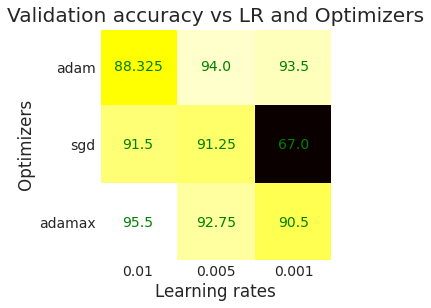

In [113]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1)

# hyper-parameters
lrs =  [0.01, 0.005, 0.001]
opt =  ['adam', 'sgd', 'adamax']

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(opt)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(lrs)

arr = np.zeros([3, 3])

print(final_res)

# loop over the different combinations of the hyper-parameters selected for our experiment.
for i in range(len(lrs)):
    for j in range(len(opt)):
        # add the values corresponding to combinations of hyper-parameters to an numpy array
        arr[j][i] = final_res[(lrs[i], opt[j])][1] * 100
        
arr = np.around(arr, 3)

plt.grid(False)
plt.xlabel('Learning rates')
plt.ylabel('Optimizers')
plt.title('Validation accuracy vs LR and Optimizers')
plt.imshow(arr, cmap='hot', interpolation='nearest')

for (j,i),label in np.ndenumerate(arr):
    ax.text(i,j,label,ha='center',va='center', color='green')

fig.savefig('heat_map_gs_lr_opt.png')
plt.show()

### Perform grid search using pooling and dropout rate parameters

In [ ]:
# Grid search using dropout rate and pooling

final_res2 = {}
for dropout in [0.3, 0.5, 0.8]:
    for pooling in ['max', 'avg']:
        _, res2 = trainAndTestModel(
            epoch = 10,
            patience = 1, # number of epochs to wait to adjust lr if monitored value does not improve
            stop_patience = 3, # number of epochs to wait before stopping training if monitored value does not improve
            threshold =.9, # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
            factor = 0.5, # factor to reduce lr by
            dwell = True, # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
            freeze = False, # if true free weights of  the base model
            ask_epoch = 100, # number of epochs to run before asking if you want to halt training
            batch = train_steps,
            lr = 0.01,
            optimizer = 'adamax',
            loss = 'categorical_crossentropy',
            dropout_rate = dropout,
            pooling = pooling
        )
        final_res2[(dropout, pooling)] = res2
        print(final_res2)

In [110]:
# temporary holding place for final_res2 (TO BE DELETED)
final_res2 = {(0.3, 'max'): [0.1572026014328003, 0.9499999785423279], (0.3, 'avg'): [0.44666028022766113, 0.8600000143051147], (0.5, 'max'): [0.42170771956443787, 0.8174999952316284], (0.5, 'avg'): [0.1878148466348648, 0.934999809265137], (0.8, 'max'): [0.18076522648334503, 0.95999761581421], (0.8, 'avg'): [0.1949423849582672, 0.944999761581421]}

### Plot results for grid search using dropout rate and pooling

{(0.3, 'max'): [0.1572026014328003, 0.9499999785423279], (0.3, 'avg'): [0.44666028022766113, 0.8600000143051147], (0.5, 'max'): [0.42170771956443787, 0.8174999952316284], (0.5, 'avg'): [0.1878148466348648, 0.934999809265137], (0.8, 'max'): [0.18076522648334503, 0.95999761581421], (0.8, 'avg'): [0.1949423849582672, 0.944999761581421]}


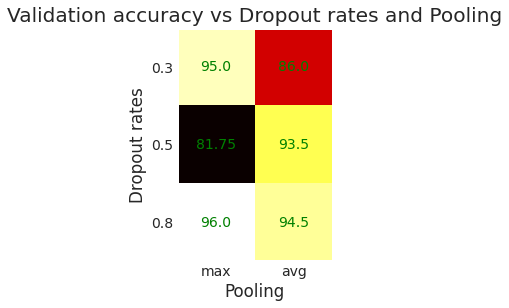

In [111]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1)

# hyper-parameters
dropout =  [0.3, 0.5, 0.8]
pooling =  ['max', 'avg']

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(dropout)

ax.set_xticks([0, 1])
ax.set_xticklabels(pooling)

arr = np.zeros([3, 2])

print(final_res2)

# loop over the different combinations of the hyper-parameters selected for our experiment.
for i in range(len(dropout)):
    for j in range(len(pooling)):
        # add the values corresponding to combinations of hyper-parameters to an numpy array
        arr[i][j] = final_res2[(dropout[i], pooling[j])][1] * 100
        
arr = np.around(arr, 3)

plt.grid(False)
plt.xlabel('Pooling')
plt.ylabel('Dropout rates')
plt.title('Validation accuracy vs Dropout rates and Pooling')
plt.imshow(arr, cmap='hot', interpolation='nearest')

for (j,i),label in np.ndenumerate(arr):
    ax.text(i,j,label,ha='center',va='center', color='green')

fig.savefig('heat_map_gs_dpo_pool.png')
plt.show()

### instantiate the calback and train the model

In [79]:
epochs = 40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 # number of epochs to wait before stopping training if monitored value does not improve
threshold = .9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = .5 # factor to reduce lr by
dwell = True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze = False # if true free weights of  the base model
batches = train_steps

class SpanHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.times = []

    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = SpanHistory()
callbacks = [LearnerCallback(model = model,model_patience = patience,stop_patience = stop_patience, model_threshold = threshold,
                   model_factor = factor,model_dwell = dwell, model_name = model_name, model_freeze = freeze, model_batches = batches,initial_epoch = 0,training_epochs = epochs), time_callback]

history = model.fit(x = train_gen, epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0)

 Training all layers using Xception. 

Starting model training ...

 1  /2       1.376    101.000  1.32823   95.389   0.00100   0.00100    val_loss    81.80  

 2  /2       1.132    100.948  1.09936   95.389   0.00100   0.00100    val_loss    84.20  

Finished training the model. Weights set from epoch with the lowest loss


### plot the data and evaluate the model on the test set

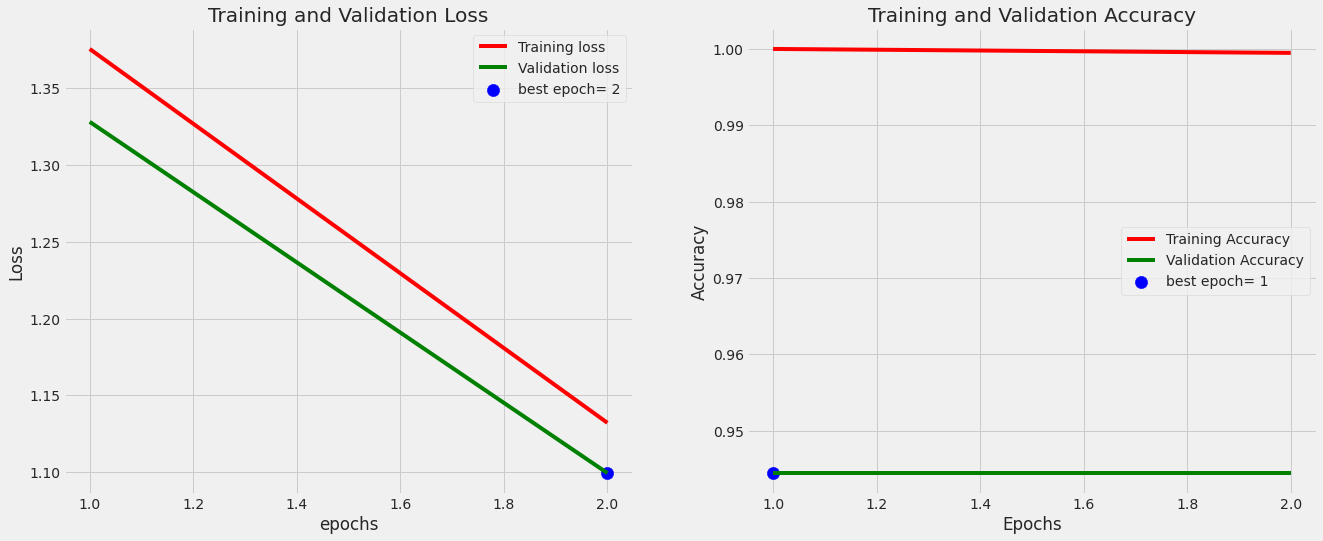

8/8 [==============================] - 29s 3s/step - loss: 1.1791 - accuracy: 0.9000

Accuracy on test set: 89.99999761581421


In [83]:
train_plot(history, 0)
acc = model.evaluate(test_gen, batch_size = test_batch_size, steps = test_steps, verbose=1)[1]*100
msg ='Accuracy on test set: ' + str(acc)
print(msg)

### define function to produce confusion matrix and classification report

In [86]:
def plot_confusion_matrix( test_gen, preds, print_code, save_dir, subject ):
    
    def retNewDict(indices_dict):
        temp_dict={}
        for key,value in indices_dict.items():
            temp_dict[value]=key
        return temp_dict
    
    pred_class=[]
    prob_list=[]
    error_list=[]
    true_class=[]
    error_indices=[]
    temp_dict={}
    y_pred=[]
    
    file_names= test_gen.filenames
    indices_dict = test_gen.class_indices
    labels = test_gen.labels
    
    temp_dict = retNewDict(indices_dict)        

    classes = list(temp_dict.values())
    dict_name = subject + '-' +str(len(classes)) +'.txt'  
    dict_path = os.path.join(save_dir,dict_name)
    dict_str=str(temp_dict)
        
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_str)

    errors=0
    
    for idx, pred in enumerate(preds):
        pred_index = np.argmax(pred)        
        true_index = labels[idx]
        if pred_index != true_index:
            error_list.append(file_names[idx])
            true_class.append(temp_dict[true_index])
            pred_class.append(temp_dict[pred_index])
            error_indices.append(true_index) 
            prob_list.append(pred[pred_index])
            errors = errors + 1
        y_pred.append(pred_index)
        
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code           
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg)              
        else:
            msg = 'Reached 100 percent accuracy. No more errors to print.'
            print(msg)

    
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in temp_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:

        y_pred=np.array(y_pred)
        y_true= np.array(labels)        
        
        clr = classification_report(y_true, y_pred, target_names=classes)   
        cm = confusion_matrix(y_true, y_pred )
        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_height= int(length * .5)
            fig_width= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length) +.5, classes, rotation= 90)
        plt.yticks(np.arange(length) +.5, classes, rotation=0)
        plt.xlabel("Prediction")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

### make predictions and generate confusion matrix and classification report

In [ ]:
# set save dir
save_dir = ""
subject = ""

print_code=0
preds=model.predict(test_gen) 
plot_confusion_matrix( test_gen, preds, print_code, save_dir, subject)  

### Plot ROC curve and find the Area under the curve

In [114]:
y_pred_keras = model.predict(test_gen)

KeyboardInterrupt: 

In [ ]:
new = y_pred_keras[:, 1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.labels, new)


auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(auc_keras)


In [ ]:
start_epoch = 0
tacc=history.history['accuracy']
Epoch_count=len(tacc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)

training_times = time_callback.times
training_times_cumu = [x/60 for x in training_times]
training_times_cumu = [sum(training_times_cumu[0:i+1]) for i in range(0,len(training_times_cumu))]
plt.plot (Epochs,training_times_cumu,'r',label= 'Epoch Training Times')
plt.title('Epoch Training Times')
plt.xlabel('Epochs')
plt.ylabel('Training Time (in minutes)')

### Temporary store for model.predict output (for easier fetching)

In [14]:
test_set_output = [[1.32054621e-02, 9.86794531e-01],
 [1.32035492e-02, 9.86796498e-01],
 [2.01296061e-02, 9.79870439e-01],
 [1.33305350e-02, 9.86669540e-01],
 [1.33460024e-02, 9.86653984e-01],
 [2.37059966e-02, 9.76293981e-01],
 [1.32219763e-02, 9.86778021e-01],
 [1.71054095e-01, 8.28945935e-01],
 [6.22842498e-02, 9.37715709e-01],
 [1.32053187e-02, 9.86794651e-01],
 [1.32245515e-02, 9.86775458e-01],
 [1.31982313e-02, 9.86801744e-01],
 [1.40904030e-02, 9.85909641e-01],
 [1.35669485e-02, 9.86433089e-01],
 [1.81015581e-02, 9.81898487e-01],
 [1.32143451e-02, 9.86785710e-01],
 [2.76475519e-01, 7.23524511e-01],
 [7.26933852e-02, 9.27306533e-01],
 [5.41974723e-01, 4.58025277e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.32368160e-02, 9.86763179e-01],
 [6.38170466e-02, 9.36182916e-01],
 [1.33891702e-02, 9.86610770e-01],
 [1.45575078e-02, 9.85442519e-01],
 [1.65451258e-01, 8.34548712e-01],
 [1.39761399e-02, 9.86023903e-01],
 [1.44682908e-02, 9.85531688e-01],
 [1.33104427e-02, 9.86689568e-01],
 [1.23099707e-01, 8.76900315e-01],
 [1.31828701e-02, 9.86817181e-01],
 [2.41935253e-02, 9.75806475e-01],
 [6.66780651e-01, 3.33219320e-01],
 [1.34615619e-02, 9.86538410e-01],
 [1.32234553e-02, 9.86776531e-01],
 [1.32223126e-02, 9.86777663e-01],
 [1.51193691e-02, 9.84880567e-01],
 [9.40570414e-01, 5.94295748e-02],
 [1.36031266e-02, 9.86396849e-01],
 [1.31875295e-02, 9.86812532e-01],
 [1.35867242e-02, 9.86413240e-01],
 [1.55464485e-02, 9.84453499e-01],
 [1.31894900e-02, 9.86810565e-01],
 [4.09055829e-01, 5.90944231e-01],
 [1.78684205e-01, 8.21315765e-01],
 [1.33524220e-02, 9.86647606e-01],
 [1.34655396e-02, 9.86534476e-01],
 [1.32005727e-02, 9.86799419e-01],
 [1.32830031e-02, 9.86716986e-01],
 [1.32321967e-02, 9.86767828e-01],
 [1.58829875e-02, 9.84117091e-01],
 [1.31859044e-02, 9.86814141e-01],
 [1.32926498e-02, 9.86707330e-01],
 [1.10875472e-01, 8.89124513e-01],
 [1.32203652e-02, 9.86779690e-01],
 [5.45583367e-01, 4.54416692e-01],
 [1.34827551e-02, 9.86517310e-01],
 [1.60002038e-02, 9.83999789e-01],
 [1.36328666e-02, 9.86367166e-01],
 [1.33693684e-02, 9.86630619e-01],
 [1.32506434e-02, 9.86749351e-01],
 [1.32204331e-02, 9.86779571e-01],
 [2.60485373e-02, 9.73951459e-01],
 [9.90911871e-02, 9.00908828e-01],
 [1.31864678e-02, 9.86813545e-01],
 [1.32551510e-02, 9.86744821e-01],
 [1.31804943e-02, 9.86819506e-01],
 [2.22658738e-02, 9.77734149e-01],
 [1.32133365e-02, 9.86786604e-01],
 [1.13003723e-01, 8.86996329e-01],
 [1.32185724e-02, 9.86781418e-01],
 [1.32757984e-02, 9.86724198e-01],
 [3.81228834e-01, 6.18771195e-01],
 [1.33437058e-02, 9.86656308e-01],
 [2.06970684e-02, 9.79302943e-01],
 [1.31923519e-02, 9.86807644e-01],
 [1.36772050e-02, 9.86322761e-01],
 [8.86528850e-01, 1.13471135e-01],
 [1.32013243e-02, 9.86798704e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.32400058e-02, 9.86760020e-01],
 [1.01460442e-01, 8.98539543e-01],
 [1.32087562e-02, 9.86791253e-01],
 [1.32056726e-02, 9.86794293e-01],
 [7.97868848e-01, 2.02131107e-01],
 [1.79354344e-02, 9.82064545e-01],
 [1.49070788e-02, 9.85092938e-01],
 [1.34344222e-02, 9.86565530e-01],
 [7.37762228e-02, 9.26223814e-01],
 [5.59414849e-02, 9.44058597e-01],
 [1.32006174e-02, 9.86799419e-01],
 [1.39743648e-02, 9.86025631e-01],
 [1.35487728e-02, 9.86451268e-01],
 [3.95766497e-01, 6.04233503e-01],
 [1.32899862e-02, 9.86710012e-01],
 [1.41853103e-02, 9.85814750e-01],
 [1.31890541e-02, 9.86810863e-01],
 [7.44169876e-02, 9.25583005e-01],
 [1.32637490e-02, 9.86736238e-01],
 [2.68378928e-02, 9.73162115e-01],
 [1.35704586e-02, 9.86429572e-01],
 [1.32397804e-02, 9.86760139e-01],
 [1.32334093e-02, 9.86766577e-01],
 [1.33089330e-02, 9.86691117e-01],
 [1.31920101e-02, 9.86808002e-01],
 [5.63130260e-01, 4.36869740e-01],
 [2.19185781e-02, 9.78081405e-01],
 [1.93974860e-02, 9.80602503e-01],
 [1.32257296e-02, 9.86774325e-01],
 [1.85136721e-02, 9.81486380e-01],
 [1.32159844e-01, 8.67840171e-01],
 [1.45913120e-02, 9.85408723e-01],
 [1.32692913e-02, 9.86730695e-01],
 [2.62408108e-02, 9.73759174e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.38767259e-02, 9.86123323e-01],
 [1.36154555e-02, 9.86384571e-01],
 [1.35554653e-02, 9.86444533e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.88466962e-02, 9.81153369e-01],
 [1.33920554e-02, 9.86607909e-01],
 [2.26574287e-01, 7.73425758e-01],
 [2.05005065e-01, 7.94994950e-01],
 [1.32090533e-02, 9.86790895e-01],
 [1.32356705e-02, 9.86764312e-01],
 [5.00350296e-02, 9.49965000e-01],
 [1.31924562e-02, 9.86807525e-01],
 [6.21256530e-01, 3.78743440e-01],
 [1.41429361e-02, 9.85857010e-01],
 [1.41620375e-02, 9.85837996e-01],
 [1.32364919e-02, 9.86763537e-01],
 [1.40427360e-02, 9.85957265e-01],
 [5.75000048e-01, 4.24999893e-01],
 [1.31974425e-02, 9.86802518e-01],
 [1.31970150e-02, 9.86802995e-01],
 [2.02195346e-02, 9.79780495e-01],
 [6.52030051e-01, 3.47969949e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.32008214e-02, 9.86799181e-01],
 [9.74013448e-01, 2.59865727e-02],
 [1.32136177e-02, 9.86786425e-01],
 [1.33493757e-02, 9.86650586e-01],
 [1.38676390e-02, 9.86132383e-01],
 [1.34302760e-02, 9.86569703e-01],
 [1.32137295e-02, 9.86786306e-01],
 [1.60075992e-01, 8.39923978e-01],
 [1.34267900e-02, 9.86573219e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.69310886e-02, 9.83068943e-01],
 [8.94301474e-01, 1.05698451e-01],
 [6.47490442e-01, 3.52509528e-01],
 [1.46956490e-02, 9.85304296e-01],
 [1.34566361e-02, 9.86543357e-01],
 [9.46074724e-02, 9.05392587e-01],
 [1.31958276e-02, 9.86804128e-01],
 [1.32248318e-02, 9.86775160e-01],
 [5.64939439e-01, 4.35060591e-01],
 [1.53152104e-02, 9.84684706e-01],
 [1.32270399e-02, 9.86772954e-01],
 [1.31950025e-02, 9.86804962e-01],
 [1.32105704e-02, 9.86789405e-01],
 [1.78264175e-02, 9.82173562e-01],
 [1.32691721e-02, 9.86730814e-01],
 [1.34971142e-02, 9.86502886e-01],
 [1.32563747e-02, 9.86743689e-01],
 [1.32416617e-02, 9.86758292e-01],
 [1.31921843e-02, 9.86807883e-01],
 [4.29525636e-02, 9.57047462e-01],
 [1.55078927e-02, 9.84492064e-01],
 [1.32027902e-02, 9.86797214e-01],
 [2.16098633e-02, 9.78390098e-01],
 [1.32210916e-02, 9.86778855e-01],
 [3.37103605e-01, 6.62896395e-01],
 [1.33306503e-01, 8.66693437e-01],
 [2.84108017e-02, 9.71589208e-01],
 [1.31976297e-02, 9.86802399e-01],
 [1.61442887e-02, 9.83855784e-01],
 [2.95997150e-02, 9.70400333e-01],
 [1.54971946e-02, 9.84502852e-01],
 [1.33737726e-02, 9.86626208e-01],
 [1.31728863e-02, 9.86827135e-01],
 [1.31970150e-02, 9.86802995e-01],
 [1.33007830e-02, 9.86699224e-01],
 [7.88936242e-02, 9.21106398e-01],
 [1.35045005e-02, 9.86495495e-01],
 [1.50633091e-02, 9.84936655e-01],
 [4.92248349e-02, 9.50775087e-01],
 [2.34107487e-02, 9.76589262e-01],
 [1.66190080e-02, 9.83381033e-01],
 [1.33038862e-02, 9.86696124e-01],
 [1.26252351e-02, 9.87374783e-01],
 [1.39973005e-02, 9.86002684e-01],
 [1.32053373e-02, 9.86794651e-01],
 [1.33569585e-02, 9.86643076e-01],
 [1.33198574e-01, 8.66801441e-01],
 [1.40642505e-02, 9.85935807e-01],
 [1.51612004e-02, 9.84838843e-01],
 [1.34344222e-02, 9.86565530e-01],
 [8.19597721e-01, 1.80402279e-01],
 [7.51356244e-01, 2.48643711e-01],
 [9.65676844e-01, 3.43231745e-02],
 [9.72637236e-01, 2.73627806e-02],
 [9.71117735e-01, 2.88822446e-02],
 [9.73403811e-01, 2.65962072e-02],
 [9.75238562e-01, 2.47613955e-02],
 [9.64573801e-01, 3.54261696e-02],
 [9.97636914e-01, 2.36307317e-03],
 [9.58308816e-01, 4.16912362e-02],
 [9.84105408e-01, 1.58945490e-02],
 [9.48936284e-01, 5.10637686e-02],
 [9.87763345e-01, 1.22366650e-02],
 [9.65412378e-01, 3.45876031e-02],
 [9.78387833e-01, 2.16121953e-02],
 [9.73729789e-01, 2.62702145e-02],
 [9.69051540e-01, 3.09485104e-02],
 [9.75946069e-01, 2.40538772e-02],
 [9.20750201e-01, 7.92497694e-02],
 [9.82111812e-01, 1.78882107e-02],
 [9.50136721e-01, 4.98632863e-02],
 [9.50513661e-01, 4.94863205e-02],
 [9.78908062e-01, 2.10918691e-02],
 [9.69188750e-01, 3.08112539e-02],
 [9.70166087e-01, 2.98338924e-02],
 [9.75128710e-01, 2.48713288e-02],
 [9.74951982e-01, 2.50479318e-02],
 [9.63293374e-01, 3.67066525e-02],
 [9.71937180e-01, 2.80627944e-02],
 [9.54601467e-01, 4.53984924e-02],
 [9.73844171e-01, 2.61558499e-02],
 [9.81040001e-01, 1.89599693e-02],
 [9.75840747e-01, 2.41592471e-02],
 [9.75202024e-01, 2.47978996e-02],
 [9.72502232e-01, 2.74977759e-02],
 [9.45089817e-01, 5.49101233e-02],
 [9.55045938e-01, 4.49540578e-02],
 [9.64375734e-01, 3.56242470e-02],
 [9.86750901e-01, 1.32490974e-02],
 [9.99096036e-01, 9.03981563e-04],
 [9.79748189e-01, 2.02518161e-02],
 [9.83877003e-01, 1.61230508e-02],
 [9.75956440e-01, 2.40435246e-02],
 [9.88383889e-01, 1.16160642e-02],
 [9.55106437e-01, 4.48935591e-02],
 [9.70738769e-01, 2.92612202e-02],
 [9.64906096e-01, 3.50939259e-02],
 [9.82580483e-01, 1.74195692e-02],
 [8.42282832e-01, 1.57717124e-01],
 [9.86421347e-01, 1.35786692e-02],
 [9.80742097e-01, 1.92579050e-02],
 [9.82809782e-01, 1.71902049e-02],
 [9.82942820e-01, 1.70572102e-02],
 [9.78017628e-01, 2.19823215e-02],
 [9.72090125e-01, 2.79098619e-02],
 [9.99192774e-01, 8.07213888e-04],
 [9.79610085e-01, 2.03899443e-02],
 [7.53863811e-01, 2.46136218e-01],
 [9.76460397e-01, 2.35396251e-02],
 [9.78109479e-01, 2.18905862e-02],
 [9.68715489e-01, 3.12845856e-02],
 [9.79208291e-01, 2.07917597e-02],
 [9.75866139e-01, 2.41338778e-02],
 [9.72212613e-01, 2.77874172e-02],
 [9.78210986e-01, 2.17890292e-02],
 [9.66822028e-01, 3.31780128e-02],
 [9.76669014e-01, 2.33309846e-02],
 [9.72301722e-01, 2.76983231e-02],
 [9.62935746e-01, 3.70642319e-02],
 [9.58820701e-01, 4.11793180e-02],
 [9.70369220e-01, 2.96307504e-02],
 [9.81816769e-01, 1.81832816e-02],
 [9.70065653e-01, 2.99342871e-02],
 [9.70894039e-01, 2.91059539e-02],
 [9.79301333e-01, 2.06986684e-02],
 [9.72254038e-01, 2.77458876e-02],
 [9.69408751e-01, 3.05912402e-02],
 [9.73439574e-01, 2.65603438e-02],
 [9.80195224e-01, 1.98047943e-02],
 [9.65063751e-01, 3.49362157e-02],
 [9.71445441e-01, 2.85545681e-02],
 [9.85320032e-01, 1.46798883e-02],
 [9.66135442e-01, 3.38645689e-02],
 [9.82331395e-01, 1.76686496e-02],
 [9.84515071e-01, 1.54849617e-02],
 [9.76376832e-01, 2.36231368e-02],
 [9.88904297e-01, 1.10956756e-02],
 [8.92587125e-01, 1.07412860e-01],
 [9.98231113e-01, 1.76889799e-03],
 [9.85019326e-01, 1.49806831e-02],
 [9.72669721e-01, 2.73303315e-02],
 [9.60743070e-01, 3.92569527e-02],
 [5.65373778e-01, 4.34626251e-01],
 [9.68327999e-01, 3.16720307e-02],
 [9.87132668e-01, 1.28673818e-02],
 [9.71005976e-01, 2.89939977e-02],
 [9.58856821e-01, 4.11431529e-02],
 [9.79955375e-01, 2.00446174e-02],
 [9.75934267e-01, 2.40656808e-02],
 [9.85455453e-01, 1.45445382e-02],
 [9.48774636e-01, 5.12253754e-02],
 [9.81435478e-01, 1.85645483e-02],
 [9.88381565e-01, 1.16184354e-02],
 [9.38971519e-01, 6.10284917e-02],
 [9.77354467e-01, 2.26454996e-02],
 [9.71298993e-01, 2.87010148e-02],
 [9.81188357e-01, 1.88116282e-02],
 [9.83590186e-01, 1.64098106e-02],
 [9.61953223e-01, 3.80467847e-02],
 [9.72734094e-01, 2.72659305e-02],
 [9.77933168e-01, 2.20668931e-02],
 [7.91807026e-02, 9.20819342e-01],
 [9.83965993e-01, 1.60340071e-02],
 [9.89676654e-01, 1.03233820e-02],
 [9.88522053e-01, 1.14779426e-02],
 [9.79649663e-01, 2.03503612e-02],
 [9.81141746e-01, 1.88582037e-02],
 [9.85861540e-01, 1.41384900e-02],
 [9.78963017e-01, 2.10370142e-02],
 [9.85574484e-01, 1.44254845e-02],
 [9.81804669e-01, 1.81953050e-02],
 [9.79508519e-01, 2.04914790e-02],
 [9.75926101e-01, 2.40739305e-02],
 [9.20444787e-01, 7.95552582e-02],
 [9.69053864e-01, 3.09461448e-02],
 [9.89821196e-01, 1.01787522e-02],
 [9.87352848e-01, 1.26471631e-02],
 [9.68039274e-01, 3.19607109e-02],
 [9.74852979e-01, 2.51469556e-02],
 [9.49545085e-01, 5.04549034e-02],
 [9.76219356e-01, 2.37806607e-02],
 [4.44611609e-01, 5.55388391e-01],
 [9.71722364e-01, 2.82776002e-02],
 [9.51280355e-01, 4.87196483e-02],
 [9.74111378e-01, 2.58885920e-02],
 [9.74420190e-01, 2.55798660e-02],
 [9.72661376e-01, 2.73386538e-02],
 [9.86094594e-01, 1.39054656e-02],
 [9.79915500e-01, 2.00844426e-02],
 [9.72183883e-01, 2.78161447e-02],
 [9.86982584e-01, 1.30173527e-02],
 [8.99768054e-01, 1.00231931e-01],
 [8.51667345e-01, 1.48332641e-01],
 [9.81247246e-01, 1.87527593e-02],
 [9.79630232e-01, 2.03697328e-02],
 [9.78377879e-01, 2.16221679e-02],
 [9.86128688e-01, 1.38713429e-02],
 [9.70202088e-01, 2.97978837e-02],
 [9.87170279e-01, 1.28297387e-02],
 [9.83715892e-01, 1.62840281e-02],
 [9.70110536e-01, 2.98894159e-02],
 [9.26405132e-01, 7.35947862e-02],
 [7.41511047e-01, 2.58488953e-01],
 [9.80500340e-01, 1.94996502e-02],
 [9.82938528e-01, 1.70614794e-02],
 [9.84149158e-01, 1.58508718e-02],
 [9.74347055e-01, 2.56529693e-02],
 [9.68839109e-01, 3.11609507e-02],
 [9.87970531e-01, 1.20294262e-02],
 [9.84759510e-01, 1.52405333e-02],
 [9.83869493e-01, 1.61304884e-02],
 [9.87485230e-01, 1.25147728e-02],
 [9.86373067e-01, 1.36268716e-02],
 [9.71584618e-01, 2.84154434e-02],
 [9.65486348e-01, 3.45136225e-02],
 [9.85513806e-01, 1.44861145e-02],
 [9.86513078e-01, 1.34869032e-02],
 [9.78605568e-01, 2.13943850e-02],
 [9.90985036e-01, 9.01496224e-03],
 [9.81224179e-01, 1.87757853e-02],
 [9.69119489e-01, 3.08805350e-02],
 [9.68280494e-01, 3.17195244e-02],
 [9.80343938e-01, 1.96561124e-02],
 [9.80265677e-01, 1.97343044e-02],
 [8.42538655e-01, 1.57461315e-01],
 [9.74709451e-01, 2.52905749e-02],
 [9.44909692e-01, 5.50902300e-02],
 [8.84030581e-01, 1.15969405e-01],
 [9.84415233e-01, 1.55846914e-02],
 [9.98912334e-01, 1.08764949e-03],
 [9.70144212e-01, 2.98557673e-02],
 [9.81771111e-01, 1.82288140e-02],
 [9.81068790e-01, 1.89311877e-02],
 [9.84234631e-01, 1.57654304e-02],
 [9.55780149e-01, 4.42198440e-02],
 [9.88668740e-01, 1.13313058e-02],
 [9.82410848e-01, 1.75891388e-02],
 [9.81311500e-01, 1.86884776e-02],
 [9.86120403e-01, 1.38795516e-02],
 [9.82124567e-01, 1.78754069e-02],
 [9.70282912e-01, 2.97171399e-02],
 [9.73614037e-01, 2.63859481e-02],
 [9.79655862e-01, 2.03441828e-02],
 [9.69099641e-01, 3.09004057e-02],
 [9.64765072e-01, 3.52349393e-02],
 [9.76767242e-01, 2.32327692e-02],
 [9.70152855e-01, 2.98471786e-02],
 [9.76357520e-01, 2.36424971e-02],
 [9.81865823e-01, 1.81341767e-02],
 [9.83113527e-01, 1.68864951e-02],
 [9.70232308e-01, 2.97677498e-02],
 [9.76020932e-01, 2.39791106e-02]]

### Find images for which the model performed well and others for which the model performed poorly

In [ ]:


print(len(test_set_output))
print(test_df.shape)

true_pos = [[test_df.filenames[i], test_set_output[i][1]]for i in range(len(test_set_output)) if test_set_output[i][1] >  test_set_output[i][0] and test_df.labels[i] == 'positive']
print(len(true_pos))
false_pos = [[test_df.filenames[i], test_set_output[i][1]] for i in range(len(test_set_output)) if test_set_output[i][1] >  test_set_output[i][0] and test_df.labels[i] == 'negative']
print(len(false_pos))
true_neg = [[test_df.filenames[i], test_set_output[i][0]] for i in range(len(test_set_output)) if test_set_output[i][1] <  test_set_output[i][0] and test_df.labels[i] == 'negative']
print(len(true_neg))
false_neg = [[test_df.filenames[i], test_set_output[i][0]] for i in range(len(test_set_output)) if test_set_output[i][1] <  test_set_output[i][0] and test_df.labels[i] == 'positive']
print(len(false_neg))





0.940570414


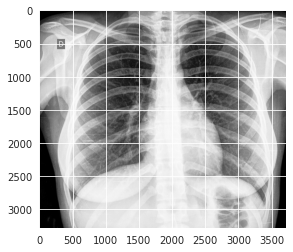

In [31]:
iter = 2
current_image = image.load_img('/kaggle/input/covidx-cxr2/test/' + false_neg[iter][0], color_mode = 'grayscale')
plt.imshow(current_image, vmin=0, vmax=255, cmap='Greys_r')

print(false_neg[iter][1])
